# Hyper

A script to detect the most hyped (popular) bands of a festival

In [1]:
# https://www.dataquest.io/blog/python-pandas-databases/

In [5]:
import sqlite3
import pandas as pd
import string
import unicodedata
import numpy as np

## Load Data

In [7]:
# Setup sqlite
sqlite_file = 'hyper.db'

# Connect to the database sqlite file
connection = sqlite3.connect(sqlite_file)
db = connection.cursor()

In [8]:
# get list of bands from db
bands = pd.read_sql_query("SELECT * FROM Bands;", connection)
print("{} bands read".format(len(bands)))
#bands.head()

268 bands read


In [9]:
# read ALL tweets from db
all_tweets = pd.read_sql_query("SELECT * FROM TweetsRaw", connection)
print("{} tweets in db".format(len(all_tweets)))

1740 tweets in db


In [10]:
# read ONLY tweets that have to be processed
tweets_to_process = pd.read_sql_query("SELECT * FROM TweetsRaw WHERE processed IS NULL", connection)
print("{} tweets to be processed".format(len(tweets_to_process)))

239 tweets to be processed


In [6]:
# read ONLY tweets that have to be processed
#tweets_to_process = pd.read_sql_query("SELECT tr.* FROM TweetsRaw AS tr \
#                                       LEFT JOIN BandTweets AS bt ON tr.id == bt.tweetRawId \
#                                       WHERE bt.tweetRawId IS NULL", connection)
#print("{} tweets to process".format(len(tweets_to_process)))

In [7]:
# tweets_to_process = tweets_to_process.head(50)
# print("{} tweets to process (!!!REMOVE!!!)".format(len(tweets_to_process)))

## Partition per band

Look for tweets talking about bands and re-create data structure in a band-centered way

In [11]:
def extract_bands(tweet):
    """
    Function that extracts the bands from a tweet text
    Returns a list of bands
    """
    
    # init list to return
    bands_in_tweet = []
    
    # loop all bands and check of any of the written forms is present in the tweet text
    for i, b in bands.iterrows():
                
        # set different band names writing possibilities
        bandname = b['name']
        bandname_lowercase = bandname.lower()
        bandname_lowercase_no_spaces = ''.join(bandname_lowercase.split())
        bandname_lowercase_no_accents = ''.join((c for c in unicodedata.normalize('NFD', bandname_lowercase) if unicodedata.category(c) != 'Mn'))
        bandname_lowercase_no_spaces_no_accents = ''.join((c for c in unicodedata.normalize('NFD', bandname_lowercase_no_spaces) if unicodedata.category(c) != 'Mn'))

        # check if any of the forms is in the tweet text
        if any(s in tweet['tweetText'].lower() for s in [bandname_lowercase, bandname_lowercase_no_spaces, bandname_lowercase_no_accents, bandname_lowercase_no_spaces_no_accents, b['twitterName']]):
            bands_in_tweet.append({"id": b['id'], "codedName": b['codedName']})

    return bands_in_tweet

In [12]:
def band_partition(tweet):
    """
    Function that reads a single tweet info and adds into a list the tweet information partitioned by bands.
    I.e. If a tweet mentions 2 bands, it adds a list of 2 dicts with the tweet info
    """
    
    # loop all bands and add an entry to the list
    for b in tweet['bands']:
        new_band_tweets_list.append({\
                                 "tweetRawId" : tweet['id'],\
                                 "createdAt" : tweet['createdAt'],\
                                 "storedAt" : tweet['storedAt'],\
                                 "bandId" : b['id'],\
                                 "bandCodedName" : b['codedName'],\
                                 "favsCount" : tweet['favsCount'],\
                                 "rtsCount" : tweet['rtsCount'],\
                                 "language" : tweet['language'],\
                                 "userId" : tweet['userId'],\
                                 "userFriendsCount" : tweet['userFriendsCount'],\
                                 "userFollowersCount" : tweet['userFollowersCount'],\
                                 "userStatusesCount" : tweet['userStatusesCount'],\
                                 "userFavsCount" : tweet['userFavsCount'],\
                                 "userLocation" : tweet['userLocation']\
                                })
    
    # Mark TweetsRaw as processed
    db.execute("UPDATE TweetsRaw SET processed = 1 WHERE id == {}".format(tweet.id))
    connection.commit()

In [13]:
if(tweets_to_process.shape[0] > 0):

    # extract bands for each tweet
    tweets_to_process['bands'] = tweets_to_process.apply(extract_bands, axis=1)

    # construct the list of tweets per band
    new_band_tweets_list = []
    tweets_to_process.apply(band_partition, axis=1);

    # create a dataframe from the previous list
    new_band_tweets = pd.DataFrame.from_dict(new_band_tweets_list)
    print("{} band-tweets".format(new_band_tweets.shape[0]))
else:
    new_band_tweets = pd.DataFrame([])
    print("No new tweets to process")

78 band-tweets


In [14]:
# Persist extracted tweets in DB (BandTweets table)
if(new_band_tweets.shape[0] > 0):
    new_band_tweets[['tweetRawId', 'bandId']].to_sql('BandTweets', connection, if_exists='append')
    print("{} new band tweets persisted".format(new_band_tweets.shape[0]))
else:
    print("No new band tweets to persist")

78 new band tweets persisted


## Explore Band-Tweet Data

In [15]:
# Construct a dataframe joining data from TweetsRaw and BandTweets
band_tweets = pd.read_sql_query("SELECT bt.bandId, \
                                        b.name AS bandName, \
                                        b.codedName AS bandCodedName, \
                                        b.headLevel AS headLevel, \
                                        tr.* \
                                 FROM BandTweets AS bt\
                                 LEFT JOIN TweetsRaw AS tr ON bt.tweetRawId == tr.id \
                                 LEFT JOIN Bands AS b ON bt.bandId == b.id", connection)
print("{} band tweets in db".format(band_tweets.shape[0]))

459 band tweets in db


In [16]:
# Count tweets per band
print(band_tweets.groupby('bandCodedName').size().sort_values(ascending=False))

bandCodedName
frankocean            32
!!!                   29
arcadefire            25
tie                   20
belako                16
solange               14
thecrabapples         14
slayer                13
keems                 12
pond                  12
glassanimals          12
runthejewels          10
boniver                8
macdemarco             8
pavvla                 8
gas                    7
seujorge               7
barbott                6
grandaddy              6
museless               6
leyya                  6
angelolsen             5
thewavepictures        5
berritxarrak           5
astronautproject       5
clubz                  4
mishima                4
hvob                   4
kinggizzard            4
rosalia                4
                      ..
phurpa                 1
theafghanwhigs         1
thedamned              1
swetshopboys           1
kevinmorby             1
descendents            1
maquinatotal           1
kink                   1
kokoshca   

In [17]:
# Count measures of a given band
bandCodedName = 'thewavepictures'
print("Tweets about {}:  {}".format(bandCodedName,band_tweets.groupby('bandCodedName').size()[bandCodedName]))
print("Total Favs of {}: {}".format(bandCodedName,band_tweets.groupby('bandCodedName').sum()['favsCount'][bandCodedName]))
print("Total RTs of {}:  {}".format(bandCodedName,band_tweets.groupby('bandCodedName').sum()['rtsCount'][bandCodedName]))

Tweets about thewavepictures:  5
Total Favs of thewavepictures: 10
Total RTs of thewavepictures:  0


## Explore Band-Tweet Timelines

In [18]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

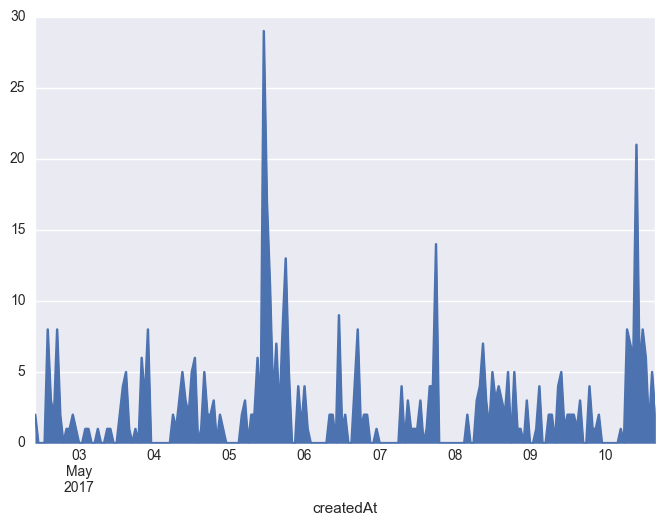

In [19]:
# timeline of tweets - all bands
# https://chrisalbon.com/python/pandas_group_data_by_time.html
band_tweets['createdAt'] = pd.to_datetime(band_tweets['createdAt'], format ='%a %b %d %H:%M:%S +0000 %Y')
band_tweets.index = band_tweets['createdAt']
band_tweets.resample('H').count()['bandId'].plot(kind='area')

/Users/eduard/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


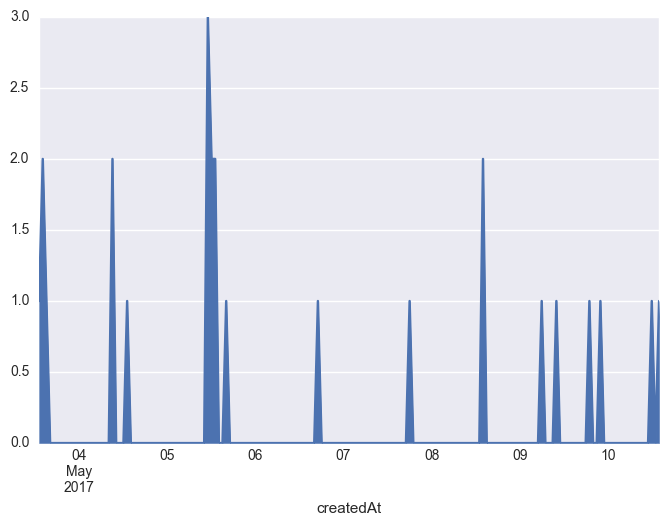

In [20]:
# timeline of tweets - single band
bandCodedName = 'arcadefire'
single_band_tweets = band_tweets[band_tweets['bandCodedName'] == bandCodedName]
single_band_tweets['createdAt'] = pd.to_datetime(single_band_tweets['createdAt'], format ='%a %b %d %H:%M:%S +0000 %Y')
single_band_tweets.index = single_band_tweets['createdAt']
single_band_tweets.resample('H').count()['bandId'].plot(kind='area')

## Hyper Score & Ranking

Create the dataframe with one row per band and all the metrics associated

In [21]:
# group and sum band tweets by band
band_hypes = band_tweets.groupby(['bandCodedName', 'bandName', 'bandId', 'headLevel']).sum()

# insert a column with the number of tweets
band_hypes['tweets'] = band_tweets.groupby(['bandCodedName', 'bandName', 'bandId', 'headLevel']).size()

# reset the index created in the group by
band_hypes = band_hypes.reset_index()

# delete not needed columns
del band_hypes['id']
del band_hypes['userFriendsCount']
del band_hypes['userFollowersCount']
del band_hypes['userStatusesCount']
del band_hypes['userFavsCount']
del band_hypes['processed']

# rename and re-order columns
band_hypes = band_hypes.rename(columns={'favsCount':'favs', 'rtsCount':'retweets'})
band_hypes = band_hypes[['bandId', 'bandCodedName', 'bandName', 'headLevel', 'tweets', 'favs', 'retweets']]

### TF-IDF revisited
- term => band
- document => all tweets
- corpus of documents => X

#### TF: Term Frequency (normalized)
Definition:
- Measures how frequently a term occurs in a document
- Measures how frequently a band is mentioned in a set of tweets

Computation:
- number of times term t appears in a document / total number of terms in the document
- number of tweets talking about that band / total number of tweets

#### IDF: Inverse Document Frequency
Definition:
- Measures how important a term
- Measures how important a band is

Computation:
- log( total number of documents / number of documents with term t in it)
- we don't have other documents so we need another way to measure how important a band is...
  - we will consider the level of headliner of the band (according to the font size used in the festival lineup poster)
  - 5 levels: 1 (top line-up) to 5 (bottom line-up)

In [22]:
# Compute BF-IHL (Band Frequency - Inverse Headline Level)
bf_numerator = band_hypes['tweets']*(band_hypes['favs'] + band_hypes['retweets'])
band_hypes['bf-ihl'] = (bf_numerator/bf_numerator.sum()) * np.log(band_hypes['headLevel'].astype(float) + 1)

#
# TODO: how do we normalize BF? total number of band_tweets? or distinct band_tweets?
#

In [23]:
# band_hypes.sort_values(by='tweets', ascending=False).head(10)
band_hypes.sort_values(by='bf-ihl', ascending=False).head(10)

,bandId,bandCodedName,bandName,headLevel,tweets,favs,retweets,bf-ihl
42,75,grandaddy,Grandaddy,3,6,1,236,0.134203
108,265,tie,Tiê,5,20,12,43,0.134178
0,1,!!!,!!!,3,29,31,18,0.134109
34,66,frankocean,Frank Ocean,1,32,30,43,0.110232
11,21,arcadefire,Arcade Fire,1,25,52,39,0.107353
52,100,keems,Keems,4,12,20,40,0.078889
102,43,thecrabapples,The Crab Apples,4,14,15,25,0.061358
84,167,pond,Pond,3,12,8,43,0.057758
14,28,belako,Belako,3,16,11,24,0.052851
88,179,runthejewels,Run The Jewels,2,10,13,42,0.041135


In [ ]:
#
#
# Persist band_hypes to DB
#
#